# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.156160,True,4.047372
1,-0.447614,False,0.032276
2,-0.821482,False,0.203869
3,0.973658,False,1.800085
4,0.146276,True,4.320628
...,...,...,...
995,0.282168,True,2.875123
996,-0.626894,False,-1.019845
997,-0.947320,True,5.106905
998,-0.814325,True,3.572179


<Axes: xlabel='v0'>

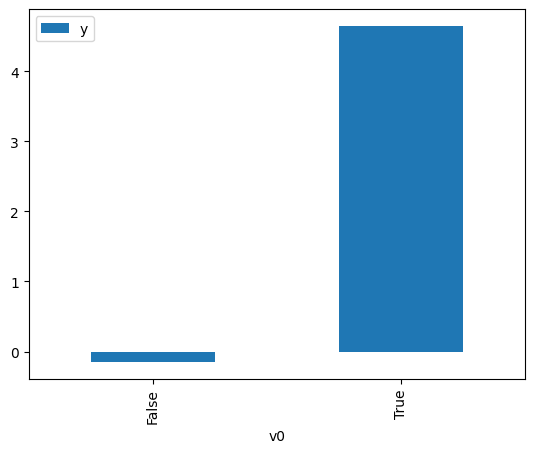

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

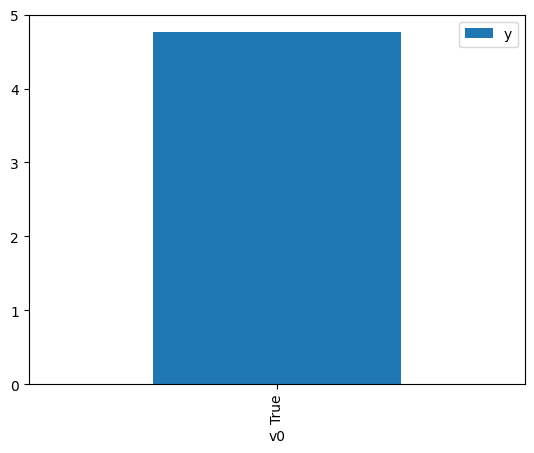

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.391606,False,1.129875,0.407403,2.454575
1,-1.593072,False,-0.917150,0.786366,1.271673
2,0.544808,False,-0.914567,0.376547,2.655714
3,0.600456,False,0.564157,0.365568,2.735469
4,-0.872761,False,-0.574416,0.666900,1.499475
...,...,...,...,...,...
995,-0.942630,False,-1.479088,0.679890,1.470826
996,-1.623136,False,-0.875413,0.790605,1.264855
997,0.446944,False,-1.890738,0.396159,2.524242
998,0.010357,False,0.646523,0.486903,2.053798


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.629680,True,3.701628,0.380201,2.630187
1,-1.076560,True,4.441415,0.295985,3.378554
2,-0.108554,True,5.198207,0.487970,2.049305
3,-0.123301,True,6.421968,0.484856,2.062469
4,-2.198825,True,3.983008,0.140003,7.142728
...,...,...,...,...,...
995,0.383466,True,6.126609,0.590935,1.692234
996,0.028366,True,4.380743,0.516900,1.934610
997,0.180009,True,3.708194,0.548801,1.822155
998,-0.394956,True,6.505974,0.427941,2.336769


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.912
Model:                            OLS   Adj. R-squared (uncentered):              0.912
Method:                 Least Squares   F-statistic:                              5194.
Date:                Thu, 17 Oct 2024   Prob (F-statistic):                        0.00
Time:                        05:12:23   Log-Likelihood:                         -1410.2
No. Observations:                1000   AIC:                                      2824.
Df Residuals:                     998   BIC:                                      2834.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4289      0.029     14.801      0.000       0.372       0.486
x2             4.9365      0.049    101.533      0.000       4.841       5.032
==============================================================================
Omnibus:                        0.680   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.712   Jarque-Bera (JB):                0.753
Skew:                          -0.004   Prob(JB):                        0.686
Kurtosis:                       2.866   Cond. No.                         1.68
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""